# Part 1: Figure 7C

Note that this figure involves capping at 15 Edman rounds, and assessing over 10 iterations the overall mean percent amino acid count.

Saved heatmap data to: plots/243273/heatmap.csv


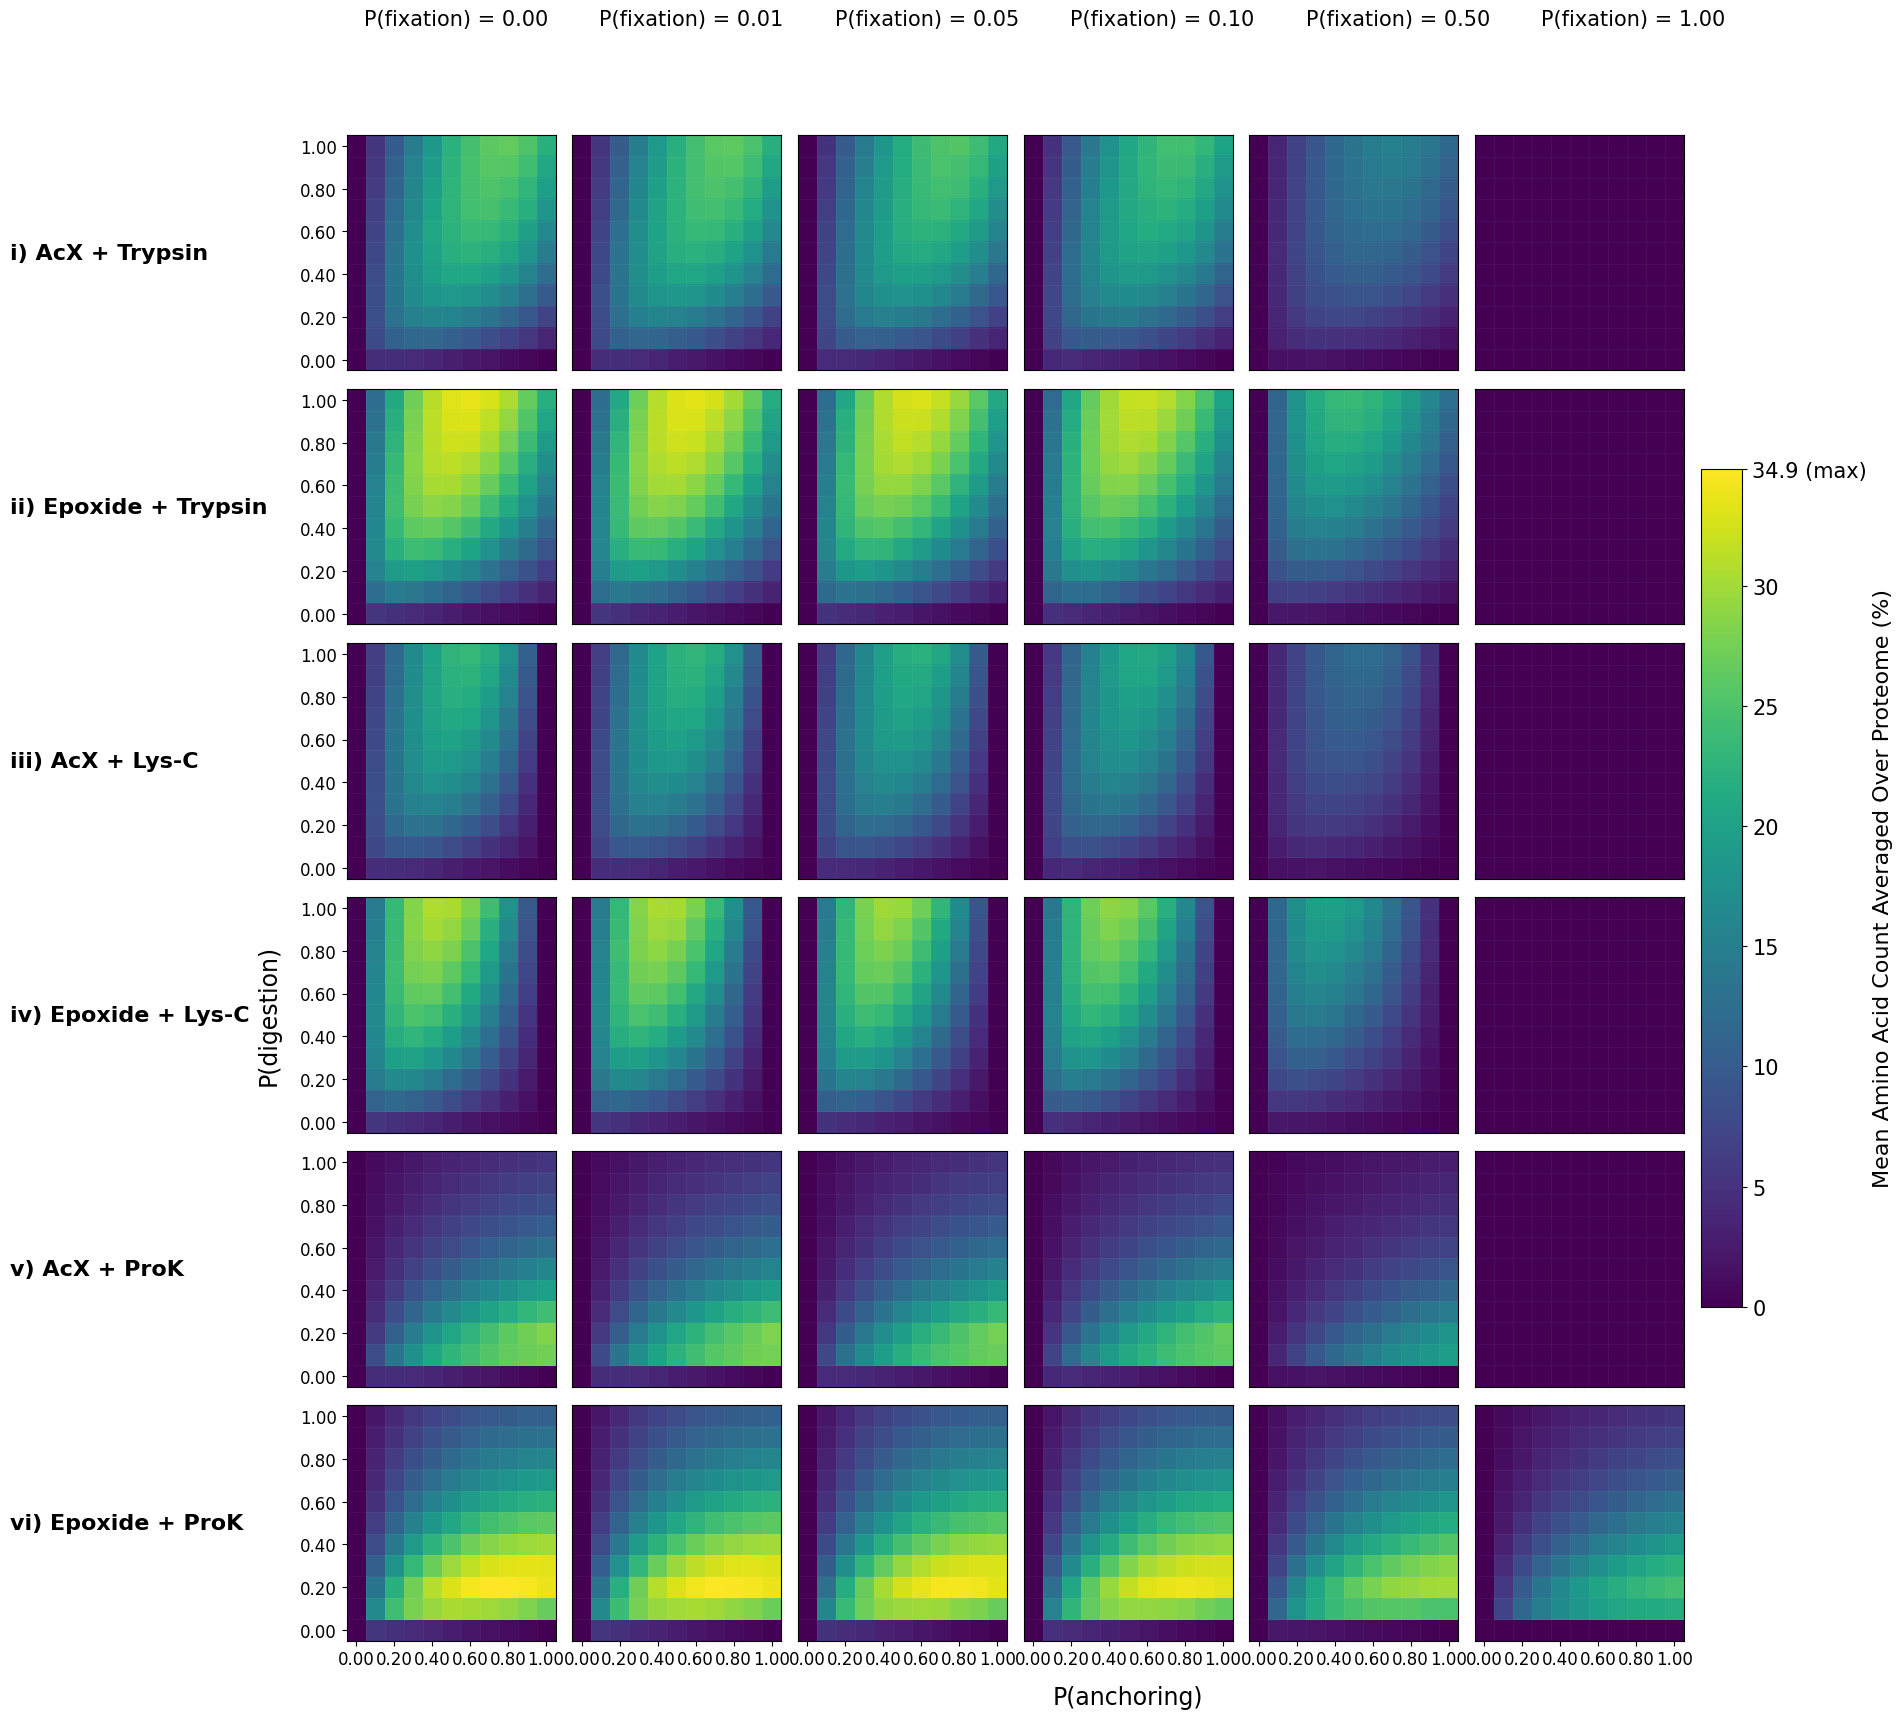

Saved: plots/243273/heatmap.png


In [ ]:
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable, get_cmap

# ---------------- Modifiable ----------------
proteome_number = "243273"   
base_dir = Path(f"sample/data/{proteome_number}")
fix_levels = [0.00, 0.01, 0.05, 0.10, 0.50, 1.00] # fixation levels to plot
save_path = Path(f"plots/{proteome_number}/heatmap.png")
save_path.parent.mkdir(parents=True, exist_ok=True)
dpi = 200
# -------------------------------------------

def load_detailed(csv_path: Path) -> pd.DataFrame:
    df = pd.read_csv(csv_path)
    for c in ["fixation", "anchoring", "digestion", "info_content"]:
        df[c] = df[c].astype(float)
    df["fix_round"]  = df["fixation"].round(2)
    df["anch_round"] = df["anchoring"].round(2)
    df["dig_round"]  = df["digestion"].round(2)
    return df

def aggregate_mean_ic(df: pd.DataFrame) -> pd.DataFrame:
    # average over replicates per protein, then average across proteins
    g_prot = (df.groupby(["protein_id","fix_round","anch_round","dig_round"], as_index=False)
                .agg(mean_ic=("info_content","mean")))
    g_param = (g_prot.groupby(["fix_round","anch_round","dig_round"], as_index=False)
                    .agg(mean_ic=("mean_ic","mean")))
    return g_param

def pivot_for_slice(g_param: pd.DataFrame, fix_value: float) -> pd.DataFrame:
    sl = g_param[g_param["fix_round"] == round(fix_value,2)].copy()
    if sl.empty:
        return pd.DataFrame()
    piv = sl.pivot(index="dig_round", columns="anch_round", values="mean_ic")
    return piv.sort_index().sort_index(axis=1)

def collect_global_axes_grid(pivots):
    all_x, all_y = set(), set()
    for _, slices in pivots:
        for _, piv in slices:
            if piv is None or piv.empty:
                continue
            all_x.update(piv.columns.values)
            all_y.update(piv.index.values)
    return sorted(all_x), sorted(all_y)

def plot_viridis_mega(pivots, xs, ys, fix_levels, out_path=None, dpi=200):
    """Shared viridis color scale across all runs, no left overlap, wide x-axis."""
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from matplotlib.colors import Normalize
    from matplotlib.cm import ScalarMappable
    from matplotlib import colormaps
    from math import floor

    # ---------- style ----------
    plt.rcParams.update({
        "font.size": 13,
        "axes.titlesize": 14,
        "axes.labelsize": 16,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "figure.titlesize": 16,
    })

    # ---------- global vmax (percent) ----------
    global_max = 1.0
    for _, slices in pivots:
        for _, piv in slices:
            if piv is None or piv.empty:
                continue
            v = np.nanmax(piv.values) * 100.0
            if np.isfinite(v) and v > global_max:
                global_max = float(v)

    norm = Normalize(vmin=0.0, vmax=global_max)
    cmap = colormaps.get_cmap("viridis")

    nrows = len(pivots)
    ncols = len(fix_levels)
    fig_w = 3.3 * ncols
    fig_h = 2.9 * nrows + 1.9
    fig, axes = plt.subplots(nrows, ncols, figsize=(fig_w, fig_h), squeeze=False)

    # Wider left margin to avoid overlap; keep right roomy but not squished
    fig.subplots_adjust(left=0.18, right=0.885, top=0.90, bottom=0.12, wspace=0.08, hspace=0.08)

    # ---------- ticks only at requested probs ----------
    desired_probs = [0.00, 0.20, 0.40, 0.60, 0.80, 1.00]
    x_idx = [i for i, x in enumerate(xs) if round(float(x), 2) in desired_probs]
    y_idx = [i for i, y in enumerate(ys) if round(float(y), 2) in desired_probs]
    x_lbls = [f"{xs[i]:.2f}" for i in x_idx]
    y_lbls = [f"{ys[i]:.2f}" for i in y_idx]

    # ---------- heatmaps ----------
    for r, (row_label, slices) in enumerate(pivots):
        slicemap = {round(f, 2): piv for f, piv in slices}
        for c, f in enumerate(fix_levels):
            ax = axes[r][c]
            piv = slicemap.get(round(f, 2), pd.DataFrame())
            if piv is None or piv.empty:
                data = np.full((len(ys), len(xs)), np.nan)
            else:
                data = piv.reindex(index=ys, columns=xs).values

            ax.imshow(data * 100.0, origin="lower", aspect="auto", cmap=cmap, norm=norm)

            if r == nrows - 1:
                ax.set_xticks(x_idx); ax.set_xticklabels(x_lbls)
            else:
                ax.set_xticks([])
            if c == 0:
                ax.set_yticks(y_idx); ax.set_yticklabels(y_lbls)
            else:
                ax.set_yticks([])

            ax.set_xticks(np.arange(-0.5, len(xs), 1), minor=True)
            ax.set_yticks(np.arange(-0.5, len(ys), 1), minor=True)
            ax.grid(which="minor", color="white", alpha=0.06, linewidth=0.5)
            ax.tick_params(which="minor", length=0)

    # ---------- row labels (pushed further left, no overlap) ----------
    for r, (row_label, _) in enumerate(pivots):
        # union bbox of row
        row_axes = [axes[r][c] for c in range(ncols)]
        y0 = min(ax.get_position().y0 for ax in row_axes)
        y1 = max(ax.get_position().y1 for ax in row_axes)
        y_center = 0.5 * (y0 + y1)

        leftmost = axes[r][0].get_position().x0
        # push label well left of y-ticks; 0.13 works well with left=0.18; tweak ±0.01 if needed
        x_left = max(0.01, leftmost - 0.53)

        fig.text(x_left, y_center, row_label, va="center", ha="left",
                 fontsize=16, fontweight="bold", clip_on=False)

    # ---------- column headers: centered, not bold ----------
    for c, f in enumerate(fix_levels):
        col_axes = [axes[r][c] for r in range(nrows)]
        x0 = min(ax.get_position().x0 for ax in col_axes)
        x1 = max(ax.get_position().x1 for ax in col_axes)
        x_center = 0.5 * (x0 + x1)
        top_bb = axes[0][c].get_position()
        y_top = top_bb.y1 + 0.055
        fig.text(x_center, y_top, f"P(fixation) = {f:.2f}",
                 va="bottom", ha="center", fontsize=15, fontweight="normal")

    # ---------- axis labels near ticks ----------
    axes[nrows // 2][0].set_ylabel("P(digestion)", fontsize=17, labelpad=14)
    axes[-1][ncols // 2].set_xlabel("P(anchoring)", fontsize=17, labelpad=12)

    # ---------- slim shared colorbar with round ticks (+ single vmax) ----------
    sm = ScalarMappable(norm=norm, cmap=cmap); sm.set_array([])
    cb = fig.colorbar(sm, ax=axes.ravel().tolist(), fraction=0.03, pad=0.012)

    step = 5.0
    stop_round = floor(global_max / step) * step
    ticks = list(np.arange(0.0, stop_round + 1e-9, step))
    if not np.isclose(global_max % step, 0.0):
        ticks.append(global_max)

    ticklabels = []
    for t in ticks:
        if np.isclose(t, global_max) and not np.isclose(global_max % step, 0.0):
            ticklabels.append(f"{t:.1f} (max)")
        else:
            ticklabels.append(f"{int(t)}" if np.isclose(t, round(t)) else f"{t:.1f}")

    cb.set_ticks(ticks)
    cb.set_ticklabels(ticklabels)
    cb.set_label("Mean Amino Acid Count Averaged Over Proteome (%)", fontsize=16)
    cb.ax.tick_params(labelsize=15)

    if out_path:
        fig.savefig(out_path, dpi=dpi)
    plt.show()
    plt.close(fig)

expected = [
    ("i) AcX + Lys-C",        "grid_acx_lysc_clamp15"),
    ("ii) AcX + Trypsin",     "grid_acx_trypsin_clamp15"),
    ("iii) AcX + ProK",       "grid_acx_prok_clamp15"),
    ("iv) Epoxide + Lys-C",   "grid_epoxide_lysc_clamp15"),
    ("v) Epoxide + Trypsin",  "grid_epoxide_trypsin_clamp15"),
    ("vi) Epoxide + ProK",    "grid_epoxide_prok_clamp15"),
]

runs = []
for label, folder in expected:
    csv_path = base_dir / folder / "grid_ic_detailed.csv"
    if csv_path.exists():
        runs.append((label, csv_path))
    else:
        print(f"[warn] missing: {csv_path}")

if not runs:
    raise RuntimeError(f"No run CSVs found under {base_dir}")

# Load and aggregate
dfs  = {label: load_detailed(path)    for label, path in runs}
aggs = {label: aggregate_mean_ic(df)  for label, df in dfs.items()}

# Build pivot slices for each fixation level
rows = []
for label, _ in runs:
    g_param = aggs[label]
    slices = [(f, pivot_for_slice(g_param, f)) for f in fix_levels]
    rows.append((label, slices))

# Unified axis grids
xs, ys = collect_global_axes_grid(rows)
if not xs or not ys:
    raise RuntimeError("No data to plot; check CSV contents/fix_levels.")

# print into csv
heatmap_out = save_path.parent / "heatmap.csv"

records = []
for label, slices in rows:
    for fix_val, piv in slices:
        if piv is None or piv.empty:
            continue
        piv_long = piv.reset_index().melt(id_vars="dig_round", var_name="anch_round", value_name="mean_ic")
        piv_long["fix_round"] = fix_val
        piv_long["run"] = label
        records.append(piv_long)

if records:
    df_out = pd.concat(records, ignore_index=True)
    df_out.to_csv(heatmap_out, index=False)
    print(f"Saved heatmap data to: {heatmap_out}")
else:
    print("No data found for heatmap CSV export.")

# plot and save
plot_viridis_mega(rows, xs, ys, fix_levels, out_path=save_path, dpi=dpi)
print("Saved:", save_path)

# Part 1: Supplementary Figures

### Supplementary Figure 13

[saved] plots/9606/histogram_fixed_point_per_condition.png
[saved] plots/9606/best_point_per_condition_clamped.csv
[saved] plots/9606/histogram_best_point_per_condition.png


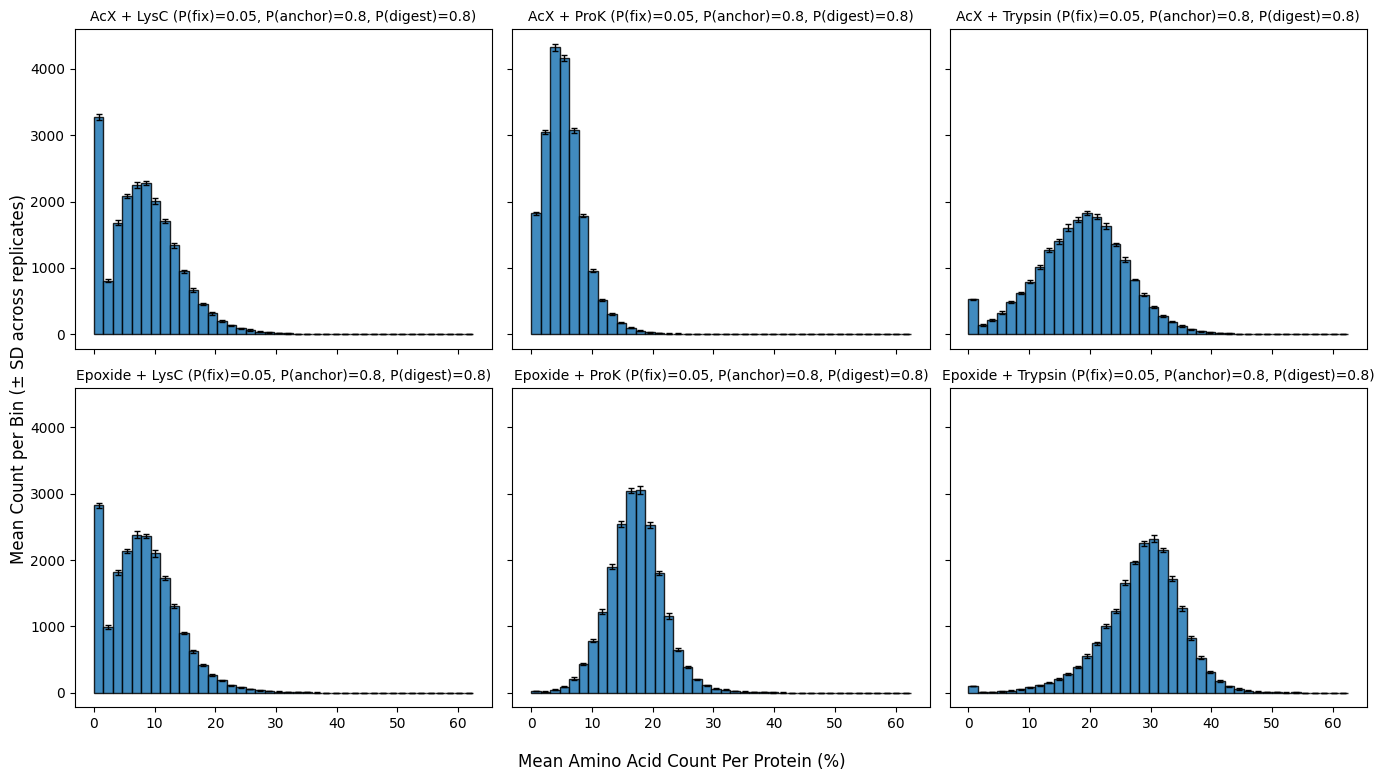

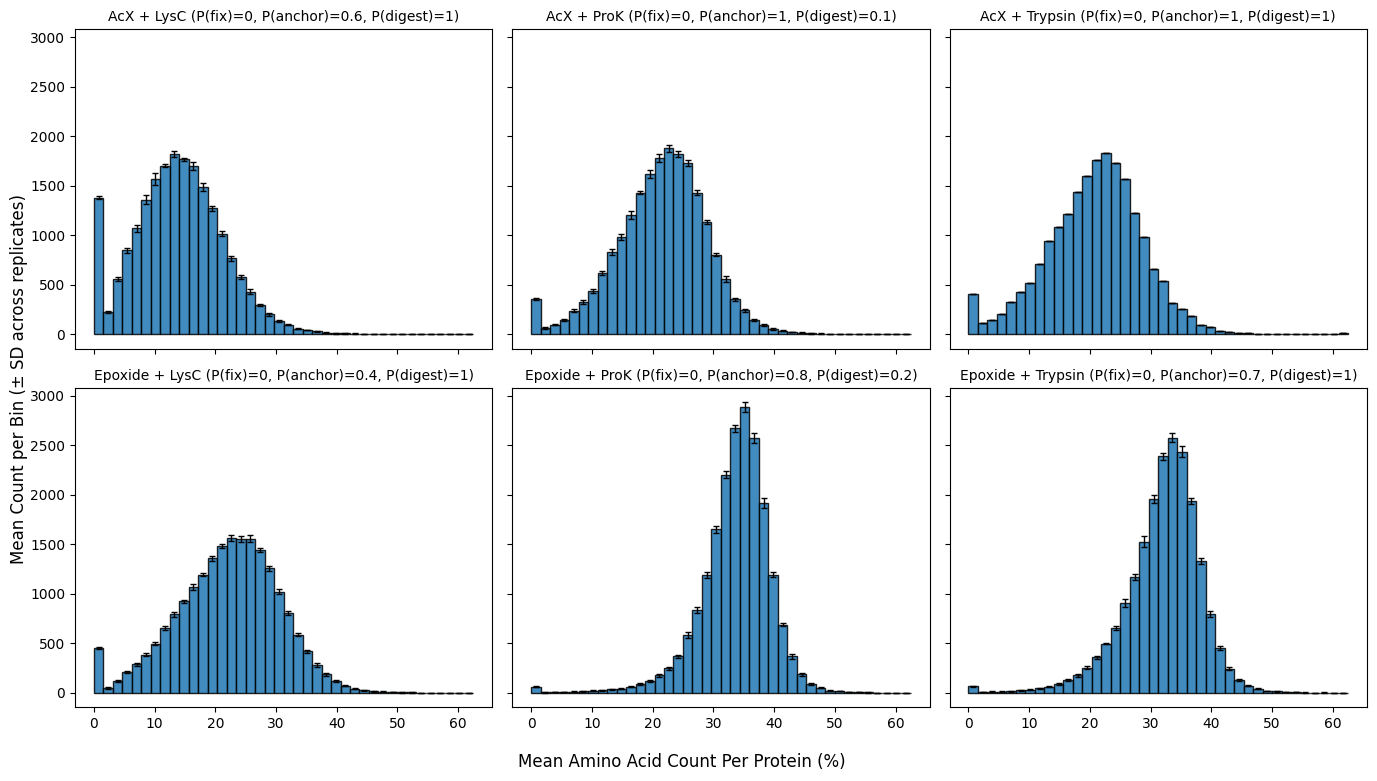

In [ ]:
#!/usr/bin/env python3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Tuple, Dict, Optional, List, Iterable

# ------------ Modifiable ---------
proteome_number = "243273"
DATA_DIR = Path(f"sample/data/{proteome_number}")
OUTDIR   = Path(f"plots/{proteome_number}")
OUTDIR.mkdir(parents=True, exist_ok=True)
# -------------------------------------------

CONDITIONS = [
    ("acx",     "lysc"),
    ("acx",     "prok"),
    ("acx",     "trypsin"),
    ("epoxide", "lysc"),
    ("epoxide", "prok"),
    ("epoxide", "trypsin"),
]

FIXED_POINT   = (0.05, 0.80, 0.80)  # (fix, anch, dig)
BINS          = 40
CHUNKSIZE     = 1_000_000           # tune to your machine
USE_PYARROW   = False               # set True if you have pyarrow installed (faster/less RAM)
EXACT_BEST    = False               # True=exact per-protein mean (more memory); False=faster approx

FIXED_FIG      = OUTDIR / "histogram_fixed_point_per_condition.png"
BEST_FIG       = OUTDIR / "histogram_best_point_per_condition.png"
BEST_TABLE_CSV = OUTDIR / "best_point_per_condition_clamped.csv"

ANCHOR_PRETTY = {"acx": "AcX", "epoxide": "Epoxide"}
DIGEST_PRETTY = {"lysc": "LysC", "prok": "ProK", "trypsin": "Trypsin"}

def ffmt(x: float) -> str:
    s = f"{x:.2f}"
    s = s.rstrip("0").rstrip(".")
    return s if s else "0"

def panel_title(anchor: str, digest: str, fix: float, anch: float, dig: float) -> str:
    return (f"{ANCHOR_PRETTY.get(anchor, anchor)} + {DIGEST_PRETTY.get(digest, digest)} "
            f"(P(fix)={ffmt(fix)}, P(anchor)={ffmt(anch)}, P(digest)={ffmt(dig)})")

def condition_csv_path(base: Path, anchor: str, digest: str) -> Path:
    return base / f"grid_{anchor}_{digest}_clamp15" / "grid_ic_detailed.csv"

# ---- Stream utils ------------------------------------------------------------
READ_KW = dict(
    usecols=["fixation", "anchoring", "digestion", "info_content", "replicate", "protein_id"],
    dtype={
        "fixation": "float32", "anchoring": "float32", "digestion": "float32",
        "info_content": "float32", "replicate": "int16", "protein_id": "string",
    },
    chunksize=CHUNKSIZE,
    engine=("pyarrow" if USE_PYARROW else "c"),
    memory_map=(not USE_PYARROW)
)

def stream_chunks(csv_path: Path) -> Iterable[pd.DataFrame]:
    if not csv_path.exists():
        return
    it = pd.read_csv(csv_path, **READ_KW)
    for chunk in it:
        # drop NA rows in critical cols
        chunk = chunk.dropna(subset=["fixation", "anchoring", "digestion", "info_content", "replicate"])
        # scale to percent once
        chunk["info_content"] = chunk["info_content"] * 100.0
        yield chunk

# ---- Fixed triple histograms (streamed) --------------------------------------
def fixed_min_max(csv_path: Path, triple: Tuple[float,float,float]) -> Tuple[float,float] | None:
    f, a, d = triple
    gmin, gmax = None, None
    for ch in stream_chunks(csv_path):
        sel = ch[(ch["fixation"]==f) & (ch["anchoring"]==a) & (ch["digestion"]==d)]
        if sel.empty: 
            continue
        mn, mx = float(sel["info_content"].min()), float(sel["info_content"].max())
        gmin = mn if gmin is None else min(gmin, mn)
        gmax = mx if gmax is None else max(gmax, mx)
    if gmin is None:
        return None
    if np.isclose(gmin, gmax):
        gmax = gmin + 1e-6
    return (gmin, gmax)

def fixed_counts_per_rep(csv_path: Path, triple: Tuple[float,float,float], edges: np.ndarray) -> Dict[int, np.ndarray]:
    f, a, d = triple
    per_rep: Dict[int, np.ndarray] = {}
    for ch in stream_chunks(csv_path):
        sel = ch[(ch["fixation"]==f) & (ch["anchoring"]==a) & (ch["digestion"]==d)]
        if sel.empty: 
            continue
        for rep, sub in sel.groupby("replicate", sort=True):
            counts, _ = np.histogram(sub["info_content"].to_numpy(), bins=edges)
            arr = per_rep.get(int(rep))
            per_rep[int(rep)] = counts.astype(float) if arr is None else (arr + counts)
    return per_rep

# ---- Best triple (streamed) --------------------------------------------------
# Two options:
#   APPROX (default): best triple by overall mean IC per (fix,anch,dig). O(#triples) memory.
#   EXACT: per-protein mean, then mean-across-proteins per triple. O(#triples × #proteins) memory.

def best_triple_approx(csv_path: Path) -> Tuple[Tuple[float,float,float], float] | None:
    # running mean per triple
    # dict[(f,a,d)] = (count, mean)
    stats: Dict[Tuple[float,float,float], Tuple[int, float]] = {}
    for ch in stream_chunks(csv_path):
        keys = ch[["fixation","anchoring","digestion"]].to_numpy()
        vals = ch["info_content"].to_numpy()
        # vectorized groupby within chunk
        df = pd.DataFrame({"f":keys[:,0], "a":keys[:,1], "d":keys[:,2], "v":vals})
        gb = df.groupby(["f","a","d"])["v"].agg(["count","mean"]).reset_index()
        for _, row in gb.iterrows():
            k = (float(row["f"]), float(row["a"]), float(row["d"]))
            c, m = stats.get(k, (0, 0.0))
            # combine means (weighted)
            c2, m2 = int(row["count"]), float(row["mean"])
            tot = c + c2
            m_comb = (m*c + m2*c2) / tot if tot else 0.0
            stats[k] = (tot, m_comb)
    if not stats:
        return None
    # pick argmax on mean
    best_k, (_, best_mean) = max(stats.items(), key=lambda kv: kv[1][1])
    return best_k, best_mean

def best_triple_exact(csv_path: Path) -> Tuple[Tuple[float,float,float], float] | None:
    # Warning: this keeps per (triple, protein_id) state; still much lighter than full DataFrame, but can be large.
    # dict[(f,a,d,protein)] = (count, mean)  # Welford-like
    per_protein: Dict[Tuple[float,float,float,str], Tuple[int, float]] = {}
    for ch in stream_chunks(csv_path):
        for (f,a,d,p), sub in ch.groupby(["fixation","anchoring","digestion","protein_id"], sort=False):
            v = sub["info_content"].to_numpy()
            c_old, m_old = per_protein.get((float(f),float(a),float(d),str(p)), (0, 0.0))
            c_new = c_old + v.size
            m_new = (m_old*c_old + float(v.mean())*v.size) / c_new
            per_protein[(float(f),float(a),float(d),str(p))] = (c_new, m_new)
    if not per_protein:
        return None
    # reduce to per-triple mean across proteins
    per_triple: Dict[Tuple[float,float,float], Tuple[int, float]] = {}
    for (f,a,d,_p), (_c, m) in per_protein.items():
        cnt, mean_acc = per_triple.get((f,a,d), (0, 0.0))
        per_triple[(f,a,d)] = (cnt+1, mean_acc + m)
    # compute mean-of-protein-means & pick best
    best_k, best_val = None, -np.inf
    for k, (cnt, sum_means) in per_triple.items():
        m = sum_means / cnt
        if m > best_val:
            best_val = m
            best_k = k
    return best_k, best_val

def hist_for_triple_stream(csv_path: Path, triple: Tuple[float,float,float], edges: np.ndarray) -> Dict[int, np.ndarray]:
    return fixed_counts_per_rep(csv_path, triple, edges)

# ---- Plot helpers ------------------------------------------------------------
def mean_sd_from_rep_counts(per_rep: Dict[int, np.ndarray]) -> Tuple[np.ndarray, np.ndarray]:
    if not per_rep:
        return np.array([]), np.array([])
    M = np.vstack([v for _, v in sorted(per_rep.items())])  # shape: (nrep, nbins)
    return M.mean(axis=0), M.std(axis=0, ddof=0)

# ===================== MAIN =====================
def main():
    # ---------------- Figure 1: fixed triple (shared bins) ----------------
    # pass 1: get global min/max across all six condition files at the fixed triple
    mins_maxs = []
    csv_paths = { (a,d): condition_csv_path(DATA_DIR, a, d) for (a,d) in CONDITIONS }
    for (a,d), p in csv_paths.items():
        mm = fixed_min_max(p, FIXED_POINT)
        if mm is not None:
            mins_maxs.append(mm)
        else:
            print(f"[warn] no rows for {a}-{d} at fixed point {FIXED_POINT} or file missing: {p}")
    if mins_maxs:
        gmin = min(m for m,_ in mins_maxs)
        gmax = max(M for _,M in mins_maxs)
    else:
        # fall back to 0..100%
        gmin, gmax = 0.0, 100.0
    if np.isclose(gmin, gmax):
        gmax = gmin + 1e-6
    fixed_edges   = np.linspace(gmin, gmax, BINS+1)
    fixed_centers = 0.5*(fixed_edges[:-1] + fixed_edges[1:])
    fixed_widths  = np.diff(fixed_edges)

    # pass 2: streamed histograms
    fixed_panels = []
    for (anchor, digest) in CONDITIONS:
        p = csv_paths[(anchor,digest)]
        per_rep = hist_for_triple_stream(p, FIXED_POINT, fixed_edges)
        mean_counts, sd_counts = mean_sd_from_rep_counts(per_rep)
        title = panel_title(anchor, digest, *FIXED_POINT)
        fixed_panels.append((title, mean_counts, sd_counts))

    fig1, axes1 = plt.subplots(2, 3, figsize=(14, 8), sharex=True, sharey=True)
    for ax, (title, mean_counts, sd_counts) in zip(axes1.ravel(), fixed_panels):
        if mean_counts.size == 0:
            ax.text(0.5, 0.5, "No data", ha="center", va="center")
            ax.set_title(title, fontsize=10)
            continue
        ax.bar(fixed_centers, mean_counts, width=fixed_widths, align="center",
               edgecolor="black", alpha=0.85)
        ax.errorbar(fixed_centers, mean_counts, yerr=sd_counts, fmt="none",
                    elinewidth=1, capsize=2, ecolor="black")
        ax.set_title(title, fontsize=10)

    fig1.supxlabel("Mean Amino Acid Count Per Protein (%)")
    fig1.supylabel("Mean Count per Bin (± SD across replicates)")
    fig1.tight_layout(rect=[0, 0, 1, 0.98])
    fig1.savefig(FIXED_FIG, dpi=220)
    print(f"[saved] {FIXED_FIG}")

    # ---------------- Figure 2: best triple per condition ----------------
    picked_rows = []
    # pass 1: find best triple for each condition (streamed)
    for (anchor, digest) in CONDITIONS:
        p = csv_paths[(anchor,digest)]
        if EXACT_BEST:
            best = best_triple_exact(p)
        else:
            best = best_triple_approx(p)
        if best is None:
            print(f"[warn] missing/empty for {anchor}-{digest}")
            picked_rows.append({"anchor":anchor, "digest":digest,
                                "fixation":np.nan, "anchoring":np.nan, "digestion":np.nan,
                                "mean_IC_percent":np.nan})
            continue
        (bf, ba, bd), mean_ic = best
        picked_rows.append({"anchor":anchor, "digest":digest,
                            "fixation":bf, "anchoring":ba, "digestion":bd,
                            "mean_IC_percent":mean_ic})

    best_table = pd.DataFrame(picked_rows)
    best_table.to_csv(BEST_TABLE_CSV, index=False)
    print(f"[saved] {BEST_TABLE_CSV}")

    # pass 2: compute shared bins across the chosen best triples
    mins_maxs = []
    for row in picked_rows:
        if np.isnan(row["fixation"]):
            continue
        p = csv_paths[(row["anchor"], row["digest"])]
        mm = fixed_min_max(p, (row["fixation"], row["anchoring"], row["digestion"]))
        if mm is not None:
            mins_maxs.append(mm)
    if mins_maxs:
        gmin = min(m for m,_ in mins_maxs); gmax = max(M for _,M in mins_maxs)
    else:
        gmin, gmax = 0.0, 100.0
    if np.isclose(gmin, gmax):
        gmax = gmin + 1e-6
    best_edges   = np.linspace(gmin, gmax, BINS+1)
    best_centers = 0.5*(best_edges[:-1] + best_edges[1:])
    best_widths  = np.diff(best_edges)

    # pass 3: streamed histograms at those best triples
    best_panels = []
    for row in picked_rows:
        anchor, digest = row["anchor"], row["digest"]
        title = f"{ANCHOR_PRETTY.get(anchor, anchor)} + {DIGEST_PRETTY.get(digest, digest)} (no data)"
        mean_counts = sd_counts = np.array([])
        if not np.isnan(row["fixation"]):
            p = csv_paths[(anchor, digest)]
            triple = (float(row["fixation"]), float(row["anchoring"]), float(row["digestion"]))
            per_rep = hist_for_triple_stream(p, triple, best_edges)
            mc, sd = mean_sd_from_rep_counts(per_rep)
            title = panel_title(anchor, digest, *triple)
            mean_counts, sd_counts = mc, sd
        best_panels.append((title, mean_counts, sd_counts))

    fig2, axes2 = plt.subplots(2, 3, figsize=(14, 8), sharex=True, sharey=True)
    for ax, (title, mean_counts, sd_counts) in zip(axes2.ravel(), best_panels):
        if mean_counts.size == 0:
            ax.text(0.5, 0.5, "No data", ha="center", va="center")
            ax.set_title(title, fontsize=10)
            continue
        ax.bar(best_centers, mean_counts, width=best_widths, align="center",
               edgecolor="black", alpha=0.85)
        ax.errorbar(best_centers, mean_counts, yerr=sd_counts, fmt="none",
                    elinewidth=1, capsize=2, ecolor="black")
        ax.set_title(title, fontsize=10)

    fig2.supxlabel("Mean Amino Acid Count Per Protein (%)")
    fig2.supylabel("Mean Count per Bin (± SD across replicates)")
    fig2.tight_layout(rect=[0, 0, 1, 0.98])
    fig2.savefig(BEST_FIG, dpi=220)
    print(f"[saved] {BEST_FIG}")

    plt.show()

if __name__ == "__main__":
    main()

### Supplementary Figure 14

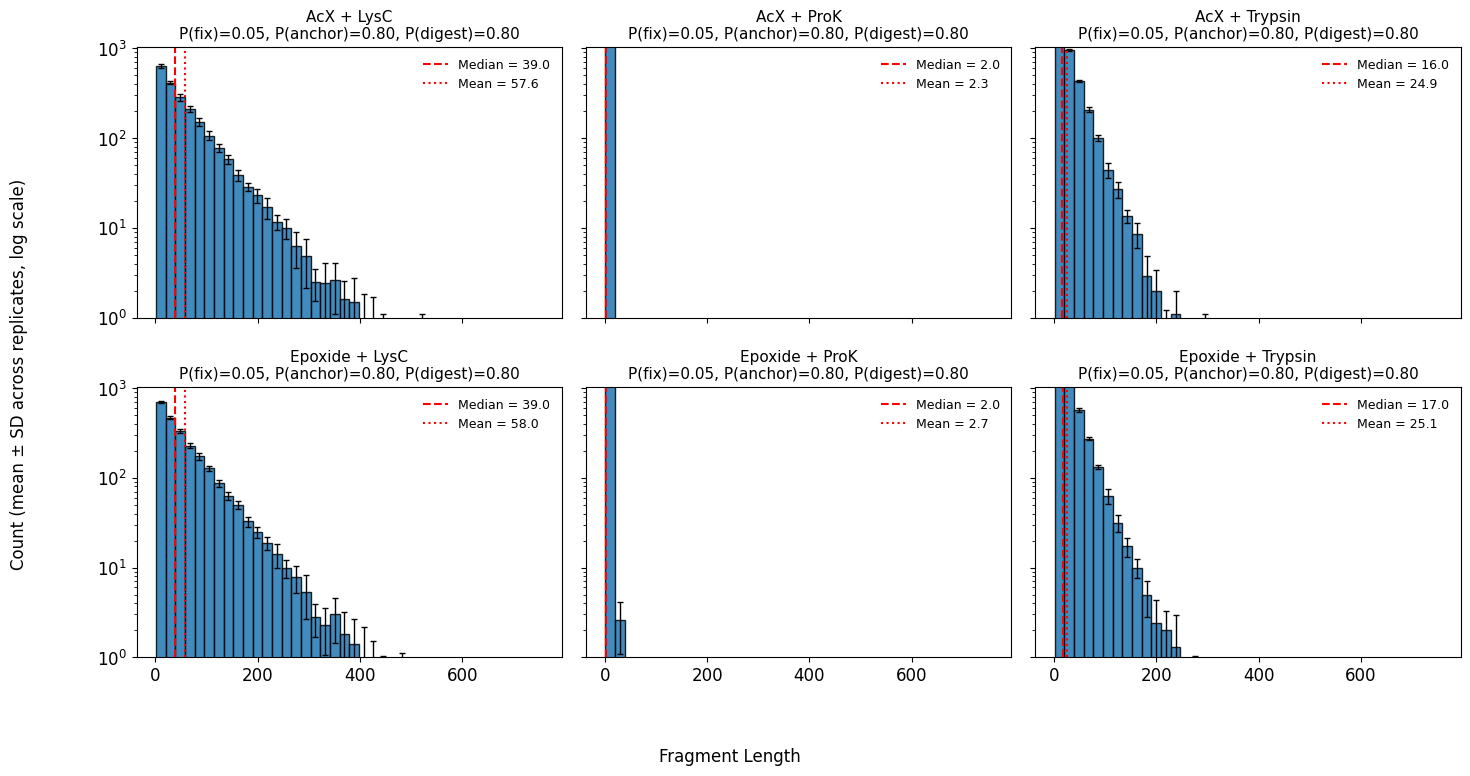

[saved] plots/243273/length_histogram_fixed_point_per_condition.png
[saved] plots/243273/best_point_per_condition_dynamic.csv


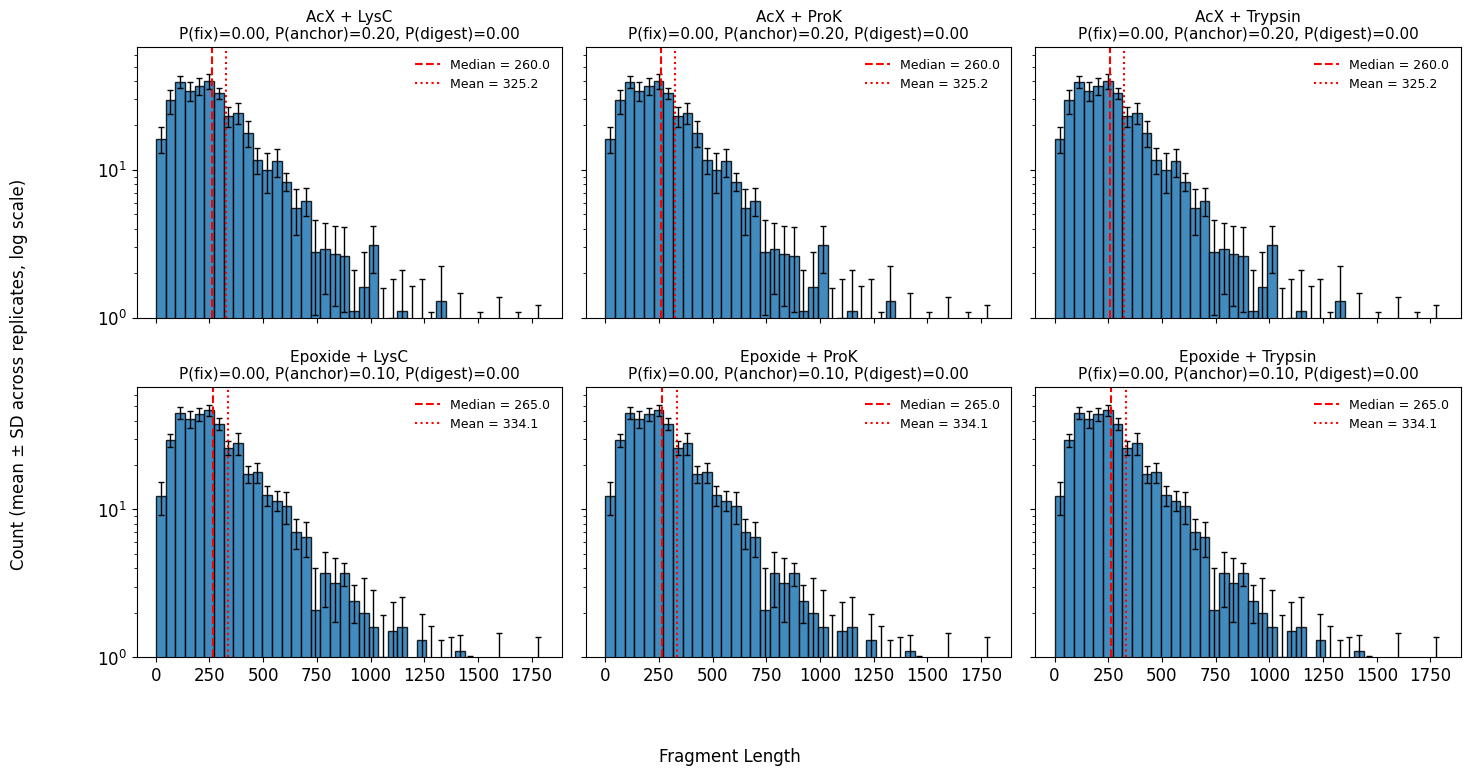

[saved] plots/243273/length_histogram_best_point_per_condition.png


In [6]:
#!/usr/bin/env python3
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Dict, List, Tuple, Optional

# ===================== CONFIG =====================
proteome_number = "243273"
BASE = Path(f"sample/data/{proteome_number}") 
OUTDIR = Path(f"plots/{proteome_number}")
OUTDIR.mkdir(parents=True, exist_ok=True)

# Fixed point (used for the first figure, same for all six conditions)
FIXED_POINT = (0.05, 0.80, 0.80)  # (fix, anch, dig)
N_BINS = 40
DPI = 220

# Output files
OUT_PNG_FIXED = OUTDIR / "length_histogram_fixed_point_per_condition.png"
OUT_PNG_BEST  = OUTDIR / "length_histogram_best_point_per_condition.png"
BEST_TABLE_CSV = OUTDIR / "best_point_per_condition_dynamic.csv"

# Conditions -> dynamic CSVs
CONDITIONS = [
    ("AcX + LysC",      BASE / "grid_acx_lysc_dynamic"     / "grid_ic_detailed.csv"),
    ("AcX + ProK",      BASE / "grid_acx_prok_dynamic"     / "grid_ic_detailed.csv"),
    ("AcX + Trypsin",   BASE / "grid_acx_trypsin_dynamic"  / "grid_ic_detailed.csv"),
    ("Epoxide + LysC",  BASE / "grid_epoxide_lysc_dynamic" / "grid_ic_detailed.csv"),
    ("Epoxide + ProK",  BASE / "grid_epoxide_prok_dynamic" / "grid_ic_detailed.csv"),
    ("Epoxide + Trypsin", BASE / "grid_epoxide_trypsin_dynamic" / "grid_ic_detailed.csv"),
]

# ===================== HELPERS =====================
def effective_length(frag: str) -> int:
    """
    Trim trailing 'X' characters (i.e., cycles with unknown residue at the end)
    and return the fragment length. Internal 'X' (non-trailing) are kept.
    """
    return len(frag.rstrip("X")) if frag else 0

def lengths_from_row(row) -> List[int]:
    """Expand fragments_json into a list of lengths (replicating by 'count')."""
    try:
        frags = json.loads(row["fragments_json"])
    except Exception:
        return []
    out = []
    for frag, count in frags.items():
        out.extend([effective_length(frag)] * int(count))
    return out

def load_df(csv_path: Path) -> Optional[pd.DataFrame]:
    if not csv_path.exists():
        print(f"[warn] missing: {csv_path}")
        return None
    df = pd.read_csv(csv_path)
    for c in ["fixation", "anchoring", "digestion", "replicate", "info_content"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    df = df.dropna(subset=["fixation","anchoring","digestion","replicate","fragments_json","info_content"])
    return df

def select_point(df: pd.DataFrame, triple: Tuple[float,float,float]) -> pd.DataFrame:
    f, a, d = triple
    return df[(df["fixation"]==f) & (df["anchoring"]==a) & (df["digestion"]==d)].copy()

def best_point_by_ic(df: pd.DataFrame) -> Tuple[Tuple[float,float,float], float]:
    """
    BEST criterion:
      1) For each (fix,anch,dig, protein_id): mean IC across replicates
      2) For each (fix,anch,dig): mean of those per-protein replicate-means
      3) Return triple with max of that mean (and the mean itself)
    """
    if "protein_id" not in df.columns:
        raise ValueError("CSV must include 'protein_id' for best-point selection.")
    per_protein = (
        df.groupby(["fixation","anchoring","digestion","protein_id"], as_index=False)["info_content"]
          .mean()
    )
    per_grid = (
        per_protein.groupby(["fixation","anchoring","digestion"], as_index=False)["info_content"]
                   .mean()
    )
    idx = per_grid["info_content"].idxmax()
    row = per_grid.loc[idx]
    triple = (float(row["fixation"]), float(row["anchoring"]), float(row["digestion"]))
    return triple, float(row["info_content"])

def lengths_by_replicate_at(df: pd.DataFrame, triple: Tuple[float,float,float]) -> Dict[int, np.ndarray]:
    """Return {replicate -> array(lengths)} filtered to triple."""
    sel = select_point(df, triple)
    reps: Dict[int, np.ndarray] = {}
    for rep, grp in sel.groupby("replicate"):
        lens: List[int] = []
        for _, row in grp.iterrows():
            lens.extend(lengths_from_row(row))
        reps[int(rep)] = np.array(lens, dtype=int) if lens else np.array([], dtype=int)
    return reps

def shared_bins_from_all(all_reps: List[Dict[int, np.ndarray]], n_bins: int) -> Tuple[np.ndarray,np.ndarray,np.ndarray]:
    """Return (edges, centers, widths) shared across a list of replicate dicts."""
    gmin, gmax = np.inf, -np.inf
    for reps in all_reps:
        for arr in reps.values():
            if arr.size:
                gmin = min(gmin, arr.min())
                gmax = max(gmax, arr.max())
    if not np.isfinite(gmax) or gmax <= 0:
        raise SystemExit("No fragments found for selected points.")
    edges = np.linspace(gmin, gmax, n_bins + 1)
    centers = 0.5 * (edges[:-1] + edges[1:])
    widths = np.diff(edges)
    return edges, centers, widths

def mean_sd_counts(reps: Dict[int, np.ndarray], edges: np.ndarray) -> Tuple[np.ndarray,np.ndarray]:
    """Per-bin mean and SD across replicates."""
    n_bins = len(edges) - 1
    H = []
    for arr in reps.values():
        if arr.size:
            counts, _ = np.histogram(arr, bins=edges)
            H.append(counts.astype(float))
        else:
            H.append(np.zeros(n_bins, dtype=float))
    H = np.vstack(H) if H else np.zeros((0,n_bins))
    mean_counts = H.mean(axis=0) if H.size else np.zeros(n_bins, dtype=float)
    sd_counts   = (H.std(axis=0, ddof=1) if H.shape[0] > 1 else np.zeros(n_bins, dtype=float))
    return mean_counts, sd_counts

def title_with_params(label: str, triple: Tuple[float,float,float]) -> str:
    f, a, d = triple
    return f"{label}\nP(fix)={f:.2f}, P(anchor)={a:.2f}, P(digest)={d:.2f}"

def plot_grid(figpath: Path, panels: List[Tuple[str, np.ndarray, np.ndarray, np.ndarray, float, float, Tuple[float,float,float]]], widths: np.ndarray):
    """
    panels: list of (label, centers, mean_counts, sd_counts, mean_len, med_len, triple)
    One global x/y label; per-panel axes have no x/y labels.
    """
    fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharex=True, sharey=True, squeeze=False)
    axes_flat = axes.ravel()

    for i, p in enumerate(panels):
        ax = axes_flat[i]
        label, centers, mean_c, sd_c, mean_len, med_len, triple = p

        ax.bar(centers, mean_c, width=widths, align="center", edgecolor="black", alpha=0.85)
        mask = mean_c > 0
        if np.any(mask):
            ax.errorbar(centers[mask], mean_c[mask], yerr=sd_c[mask],
                        fmt="none", elinewidth=1, capsize=2, ecolor="black")

        if np.isfinite(med_len):
            ax.axvline(med_len, color="red", linestyle="--", linewidth=1.5,
                       label=f"Median = {med_len:.1f}")
        if np.isfinite(mean_len):
            ax.axvline(mean_len, color="red", linestyle=":", linewidth=1.5,
                       label=f"Mean = {mean_len:.1f}")

        ax.set_title(title_with_params(label, triple), fontsize=11)
        ax.set_yscale("log"); ax.set_ylim(bottom=1)
        # no per-axes labels; we’ll set global labels below
        ax.legend(fontsize=9, frameon=False, loc="upper right")

    # Hide any unused panels (shouldn’t happen with 6)
    for j in range(len(panels), 6):
        axes_flat[j].axis("off")

    # Global axis labels (one x and one y for the whole grid)
    fig.supxlabel("Fragment Length", fontsize=12)
    fig.supylabel("Count (mean ± SD across replicates, log scale)", fontsize=12)

    plt.tight_layout(rect=[0.04, 0.04, 1, 0.98])
    plt.show()
    fig.savefig(figpath, dpi=DPI)
    plt.close(fig)
    print(f"[saved] {figpath}")

# ===================== MAIN FLOW =====================
def main():
    # Load all dataframes
    loaded: Dict[str, Optional[pd.DataFrame]] = {}
    for label, csv in CONDITIONS:
        loaded[label] = load_df(csv)

    # ---------------- Figure 1: FIXED point (same triple for all) ----------------
    fixed_reps_list = []
    fixed_panels = []
    for label, _ in CONDITIONS:
        df = loaded[label]
        reps = lengths_by_replicate_at(df, FIXED_POINT) if df is not None else {}
        fixed_reps_list.append(reps)

    # shared bins for FIXED
    edges_fixed, centers_fixed, widths_fixed = shared_bins_from_all(fixed_reps_list, N_BINS)

    # build panels for FIXED
    for (label, _), reps in zip(CONDITIONS, fixed_reps_list):
        if not reps:
            mean_c = np.zeros(len(edges_fixed)-1)
            sd_c   = np.zeros_like(mean_c)
            mean_len = np.nan; med_len = np.nan
        else:
            mean_c, sd_c = mean_sd_counts(reps, edges_fixed)
            pooled = np.concatenate([a for a in reps.values() if a.size]) if reps else np.array([], dtype=int)
            mean_len = float(np.mean(pooled)) if pooled.size else np.nan
            med_len  = float(np.median(pooled)) if pooled.size else np.nan
        fixed_panels.append((label, centers_fixed, mean_c, sd_c, mean_len, med_len, FIXED_POINT))

    plot_grid(OUT_PNG_FIXED, fixed_panels, widths_fixed)

    # ---------------- Figure 2: BEST point per condition (by IC) ----------------
    best_triples = []
    best_reps_list = []
    best_rows = []

    for label, _ in CONDITIONS:
        df = loaded[label]
        if df is None or df.empty:
            best_triples.append((np.nan, np.nan, np.nan))
            best_reps_list.append({})
            best_rows.append({"condition": label, "fixation": np.nan, "anchoring": np.nan,
                              "digestion": np.nan, "mean_IC": np.nan})
            continue
        triple, mean_ic = best_point_by_ic(df)
        reps = lengths_by_replicate_at(df, triple)
        best_triples.append(triple)
        best_reps_list.append(reps)
        best_rows.append({"condition": label, "fixation": triple[0], "anchoring": triple[1],
                          "digestion": triple[2], "mean_IC": mean_ic})

    # save table of best points
    pd.DataFrame(best_rows).to_csv(BEST_TABLE_CSV, index=False)
    print(f"[saved] {BEST_TABLE_CSV}")

    # shared bins for BEST
    edges_best, centers_best, widths_best = shared_bins_from_all(best_reps_list, N_BINS)

    # build panels for BEST
    best_panels = []
    for (label, _), reps, triple in zip(CONDITIONS, best_reps_list, best_triples):
        if not reps or any(np.isnan(triple)):
            mean_c = np.zeros(len(edges_best)-1)
            sd_c   = np.zeros_like(mean_c)
            mean_len = np.nan; med_len = np.nan
            triple_tuple = (np.nan, np.nan, np.nan)
        else:
            mean_c, sd_c = mean_sd_counts(reps, edges_best)
            pooled = np.concatenate([a for a in reps.values() if a.size]) if reps else np.array([], dtype=int)
            mean_len = float(np.mean(pooled)) if pooled.size else np.nan
            med_len  = float(np.median(pooled)) if pooled.size else np.nan
            triple_tuple = triple
        best_panels.append((label, centers_best, mean_c, sd_c, mean_len, med_len, triple_tuple))

    plot_grid(OUT_PNG_BEST, best_panels, widths_best)

if __name__ == "__main__":
    main()

### Supplementary Figure 17

[saved] plots/9606/heatmap.csv


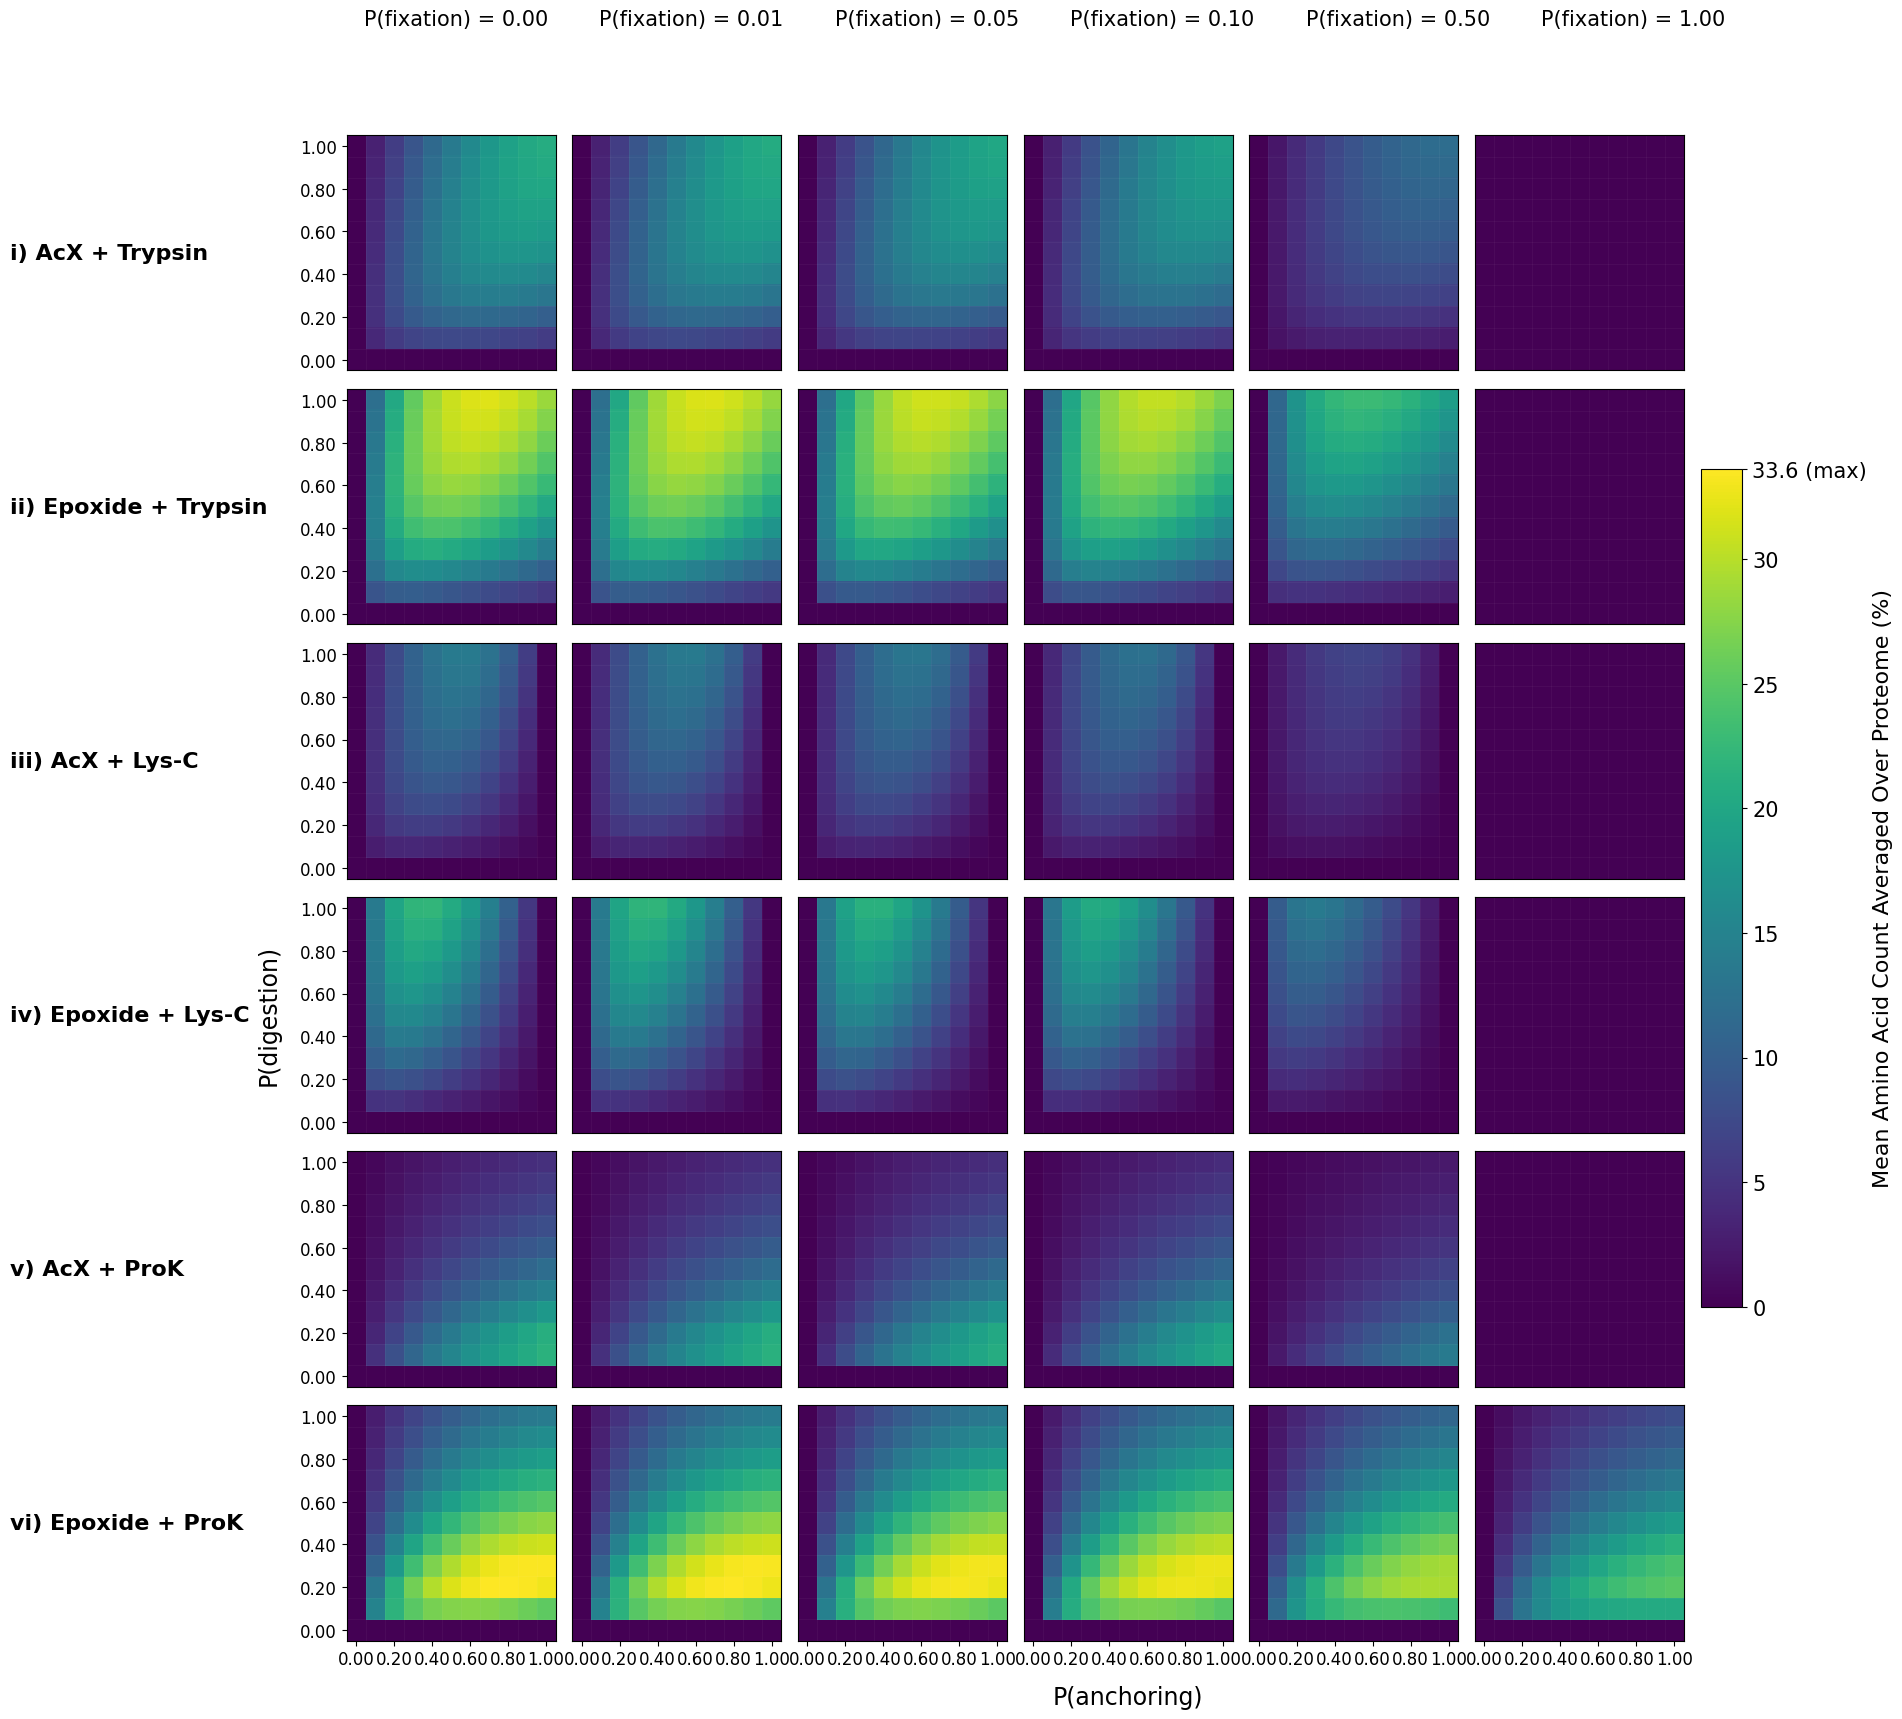

[saved] plots/9606/heatmap.png


In [ ]:
#!/usr/bin/env python3
from pathlib import Path
from math import floor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# ---------------- Modifiable ----------------
proteome_number = "9606"
base_dir = Path(f"sample/data/{proteome_number}")
fix_levels   = [0.00, 0.01, 0.05, 0.10, 0.50, 1.00]  # fixation levels to plot
plot_dir     = Path(f"plots/{proteome_number}")
plot_dir.mkdir(parents=True, exist_ok=True)
save_path    = plot_dir / "heatmap.png"          # renamed output
csv_out      = plot_dir / "heatmap.csv"          # new CSV summary
dpi          = 200

# CSV reading knobs
CHUNKSIZE    = 1_000_000          # tune to your RAM
USE_PYARROW  = False              # set True if you have pyarrow installed (faster)
# -------------------------------------------

expected = [
    ("i) AcX + Lys-C",        "grid_acx_lysc_clamp15"),
    ("ii) AcX + Trypsin",     "grid_acx_trypsin_clamp15"),
    ("iii) AcX + ProK",       "grid_acx_prok_clamp15"),
    ("iv) Epoxide + Lys-C",   "grid_epoxide_lysc_clamp15"),
    ("v) Epoxide + Trypsin",  "grid_epoxide_trypsin_clamp15"),
    ("vi) Epoxide + ProK",    "grid_epoxide_prok_clamp15"),
]

# ---------- Helpers ----------
fix_set = {round(x, 2) for x in fix_levels}

def snap_to_levels(x: float, valid: set[float], tol=1e-6) -> float:
    """Snap x to the nearest valid fixation level (to fix floating-point drift)."""
    for v in valid:
        if abs(x - v) < tol:
            return v
    return x

READ_KW = dict(
    usecols=["fixation", "anchoring", "digestion", "info_content", "replicate", "protein_id"],
    dtype={
        "fixation":"float32","anchoring":"float32","digestion":"float32",
        "info_content":"float32","replicate":"int16","protein_id":"string",
    },
    chunksize=CHUNKSIZE,
    engine=("pyarrow" if USE_PYARROW else "c"),
    memory_map=(not USE_PYARROW)
)

def stream_chunks(csv_path: Path):
    if not csv_path.exists():
        return
    it = pd.read_csv(csv_path, **READ_KW)
    for ch in it:
        ch = ch.dropna(subset=["fixation","anchoring","digestion","info_content","replicate","protein_id"])
        ch["info_content"] = ch["info_content"] * 100.0
        ch["fix_round"]  = ch["fixation"].round(2)
        ch["anch_round"] = ch["anchoring"].round(2)
        ch["dig_round"]  = ch["digestion"].round(2)
        # Snap fixation to nearest valid level
        ch["fix_round"] = ch["fix_round"].apply(lambda v: snap_to_levels(v, fix_set))
        ch = ch[ch["fix_round"].isin(fix_set)]
        if not ch.empty:
            yield ch

# ---------- Aggregation ----------
def aggregate_run_stream(csv_path: Path, run_label: str):
    """
    Streamed aggregation:
      mean over replicates per (protein_id, fix, anch, dig),
      then mean over proteins per (fix, anch, dig).
    Returns:
      - slice_pivots: list[(fix, pivot_df)]
      - xs, ys: sorted axis values
      - global_max: overall vmax for this run
      - summary_rows: list of dicts for CSV output
    """
    per_protein = {}

    for ch in stream_chunks(csv_path):
        gb = (ch.groupby(["protein_id","fix_round","anch_round","dig_round"], sort=False)["info_content"]
                .agg(["count","sum"]).reset_index())
        for _, row in gb.iterrows():
            k = (row["fix_round"], row["anch_round"], row["dig_round"], str(row["protein_id"]))
            c_old, s_old = per_protein.get(k, (0, 0.0))
            per_protein[k] = (c_old + int(row["count"]), s_old + float(row["sum"]))

    if not per_protein:
        return [], [], [], 1.0, []

    # per (fix, anch, dig): average of protein means
    per_grid = {}
    for (f,a,d,_p), (c,s) in per_protein.items():
        prot_mean = s / c
        key = (float(f), float(a), float(d))
        S, N = per_grid.get(key, (0.0, 0))
        per_grid[key] = (S + prot_mean, N + 1)

    slice_pivots = []
    all_x, all_y = set(), set()
    global_max = 1.0
    summary_rows = []

    for f in sorted(fix_set):
        entries = [(a, d, S/N) for (ff, a, d), (S, N) in per_grid.items() if round(ff, 2) == round(f, 2)]
        if not entries:
            slice_pivots.append((f, pd.DataFrame()))
            continue
        df = pd.DataFrame(entries, columns=["anch_round","dig_round","mean_ic"])
        piv = df.pivot(index="dig_round", columns="anch_round", values="mean_ic").sort_index().sort_index(axis=1)
        slice_pivots.append((f, piv))
        all_x.update(piv.columns.values.tolist())
        all_y.update(piv.index.values.tolist())
        vmax = float(np.nanmax(piv.values)) if piv.size else 0.0
        if np.isfinite(vmax) and vmax > global_max:
            global_max = vmax
        # Save for CSV output
        for (a, d, val) in entries:
            summary_rows.append({
                "run_label": run_label,
                "fixation": f,
                "anchoring": a,
                "digestion": d,
                "mean_ic_percent": val
            })

    xs = sorted(all_x)
    ys = sorted(all_y)
    return slice_pivots, xs, ys, global_max, summary_rows

# ---------- Plotting ----------
def plot_viridis_mega(pivots, xs, ys, fix_levels, global_max, out_path=None, dpi=200):
    plt.rcParams.update({
        "font.size": 13, "axes.titlesize": 14, "axes.labelsize": 16,
        "xtick.labelsize": 12, "ytick.labelsize": 12, "figure.titlesize": 16,
    })

    norm = Normalize(vmin=0.0, vmax=global_max)
    cmap = plt.colormaps.get_cmap("viridis")

    nrows = len(pivots)
    ncols = len(fix_levels)
    fig_w = 3.3 * ncols
    fig_h = 2.9 * nrows + 1.9
    fig, axes = plt.subplots(nrows, ncols, figsize=(fig_w, fig_h), squeeze=False)
    fig.subplots_adjust(left=0.18, right=0.885, top=0.90, bottom=0.12, wspace=0.08, hspace=0.08)

    desired_probs = [0.00, 0.20, 0.40, 0.60, 0.80, 1.00]
    x_idx = [i for i, x in enumerate(xs) if round(float(x), 2) in desired_probs]
    y_idx = [i for i, y in enumerate(ys) if round(float(y), 2) in desired_probs]
    x_lbls = [f"{xs[i]:.2f}" for i in x_idx]
    y_lbls = [f"{ys[i]:.2f}" for i in y_idx]

    for r, (row_label, slices) in enumerate(pivots):
        slicemap = {round(f, 2): piv for f, piv in slices}
        for c, f in enumerate(fix_levels):
            ax = axes[r][c]
            piv = slicemap.get(round(f, 2), pd.DataFrame())
            if piv is None or piv.empty:
                data = np.full((len(ys), len(xs)), np.nan)
            else:
                data = piv.reindex(index=ys, columns=xs).values

            ax.imshow(data, origin="lower", aspect="auto", cmap=cmap, norm=norm)

            if r == nrows - 1:
                ax.set_xticks(x_idx); ax.set_xticklabels(x_lbls)
            else:
                ax.set_xticks([])
            if c == 0:
                ax.set_yticks(y_idx); ax.set_yticklabels(y_lbls)
            else:
                ax.set_yticks([])

            ax.set_xticks(np.arange(-0.5, len(xs), 1), minor=True)
            ax.set_yticks(np.arange(-0.5, len(ys), 1), minor=True)
            ax.grid(which="minor", color="white", alpha=0.06, linewidth=0.5)
            ax.tick_params(which="minor", length=0)

    # row labels
    for r, (row_label, _) in enumerate(pivots):
        row_axes = [axes[r][c] for c in range(ncols)]
        y0 = min(ax.get_position().y0 for ax in row_axes)
        y1 = max(ax.get_position().y1 for ax in row_axes)
        y_center = 0.5 * (y0 + y1)
        leftmost = axes[r][0].get_position().x0
        x_left = max(0.01, leftmost - 0.53)
        fig.text(x_left, y_center, row_label, va="center", ha="left",
                 fontsize=16, fontweight="bold", clip_on=False)

    # column headers
    for c, f in enumerate(fix_levels):
        col_axes = [axes[r][c] for r in range(nrows)]
        x0 = min(ax.get_position().x0 for ax in col_axes)
        x1 = max(ax.get_position().x1 for ax in col_axes)
        x_center = 0.5 * (x0 + x1)
        top_bb = axes[0][c].get_position()
        y_top = top_bb.y1 + 0.055
        fig.text(x_center, y_top, f"P(fixation) = {f:.2f}",
                 va="bottom", ha="center", fontsize=15, fontweight="normal")

    axes[nrows // 2][0].set_ylabel("P(digestion)", fontsize=17, labelpad=14)
    axes[-1][ncols // 2].set_xlabel("P(anchoring)", fontsize=17, labelpad=12)

    sm = ScalarMappable(norm=norm, cmap=cmap); sm.set_array([])
    cb = fig.colorbar(sm, ax=axes.ravel().tolist(), fraction=0.03, pad=0.012)

    step = 5.0
    stop_round = floor(global_max / step) * step
    ticks = list(np.arange(0.0, stop_round + 1e-9, step))
    if not np.isclose(global_max % step, 0.0):
        ticks.append(global_max)
    ticklabels = []
    for t in ticks:
        if np.isclose(t, global_max) and not np.isclose(global_max % step, 0.0):
            ticklabels.append(f"{t:.1f} (max)")
        else:
            ticklabels.append(f"{int(t)}" if np.isclose(t, round(t)) else f"{t:.1f}")
    cb.set_ticks(ticks)
    cb.set_ticklabels(ticklabels)
    cb.set_label("Mean Amino Acid Count Averaged Over Proteome (%)", fontsize=16)
    cb.ax.tick_params(labelsize=15)

    if out_path:
        fig.savefig(out_path, dpi=dpi)
    plt.show()
    plt.close(fig)

# ---------- Main ----------
def main():
    runs = []
    for label, folder in expected:
        csv_path = base_dir / folder / "grid_ic_detailed.csv"
        if csv_path.exists():
            runs.append((label, csv_path))
        else:
            print(f"[warn] missing: {csv_path}")
    if not runs:
        raise RuntimeError(f"No run CSVs found under {base_dir}")

    rows = []
    global_xs, global_ys = set(), set()
    global_max = 1.0
    all_summary_rows = []

    for label, csv_path in runs:
        slice_pivots, xs, ys, vmax, summary_rows = aggregate_run_stream(csv_path, label)
        rows.append((label, slice_pivots))
        global_xs.update(xs); global_ys.update(ys)
        all_summary_rows.extend(summary_rows)
        if np.isfinite(vmax) and vmax > global_max:
            global_max = vmax

    xs = sorted(global_xs); ys = sorted(global_ys)
    if not xs or not ys:
        raise RuntimeError("No data to plot; check CSV contents and fix_levels.")

    # Save combined CSV of all runs
    if all_summary_rows:
        df_out = pd.DataFrame(all_summary_rows)
        df_out.to_csv(csv_out, index=False)
        print(f"[saved] {csv_out}")

    plot_viridis_mega(rows, xs, ys, fix_levels, global_max, out_path=save_path, dpi=dpi)
    print(f"[saved] {save_path}")

if __name__ == "__main__":
    main()
